In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import requests
import pyvo as vo
import torch
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm import tqdm
from astropy.io import fits
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import torch.nn as nn
from mambapy.mamba import Mamba, MambaConfig
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Main Function

In [3]:
def predict_star_labels(gaia_ids, model_path, lamost_catalogue, gaia_transformer_path):
    """
    Given a list of Gaia DR3 IDs, this function:
    1) Queries Gaia for star parameters.
    2) Cross-matches with LAMOST spectra.
    3) Downloads and processes LAMOST spectra.
    4) Normalizes both Gaia and LAMOST data.
    5) Applies a trained StarClassifierFusion model to predict labels.
    
    Returns:
        DataFrame with Gaia IDs and predicted multi-label classifications.
    """

    print("\n🚀 Step 1: Querying Gaia data...")
    print("🔗 Gaia IDs:", len(gaia_ids))
    df_gaia = query_gaia_data(gaia_ids)
    if df_gaia.empty:
        print("⚠️ No Gaia data found. Exiting.")
        return None
    print("🔗 Gaia data:", df_gaia.shape)

    print("\n🔄 Step 2: Cross-matching with LAMOST catalog...")
    
    df_matched = crossmatch_lamost(df_gaia, lamost_catalogue)
    if df_matched.empty:
        print("⚠️ No LAMOST matches found. Exiting.")
        return None

    print("\n📥 Step 3: Downloading LAMOST spectra (if needed)...")
    obsids = df_matched["obsid"].unique()
    spectra_folder = "lamost_spectra_uniques"
    download_lamost_spectra(obsids, save_folder=spectra_folder, num_workers=500)

    print("\n🔧 Step 4: Converting from FITS LAMOST spectra...")
    #process_lamost_fits_files(folder_path=spectra_folder, output_file="Pickles/lamost_data.csv")
    process_lamost_fits_files(folder_path="lamost_spectra_uniques", 
                          output_file="Pickles/lamost_data.csv", 
                          matched_obsids=obsids)

    print("\n📊 Step 5: Extracting and saving flux & frequency values...")
    extract_flux_frequency_from_csv(csv_path="Pickles/lamost_data.csv")

    print("\n📊 Step 6: Interpolating and normalizing LAMOST spectra...")
    nan_files = interpolate_spectrum("Pickles/flux_values.pkl", "Pickles/freq_values.pkl", "Pickles/lamost_data_interpolated.pkl")
    spectrum_interpolated = pd.read_pickle("Pickles/lamost_data_interpolated.pkl")
    spectrum_normalized = normalize_lamost_spectra(spectrum_interpolated)

    if spectrum_normalized.empty:
        print("⚠️ No processed LAMOST spectra found. Exiting.")
        return None

    print("\n📊 Step 7: Normalizing Gaia data...")
    with open(gaia_transformer_path, "rb") as f:
        gaia_transformers = pickle.load(f)   # Dict of {col_name: fitted PowerTransformer}
    gaia_normalized = apply_gaia_transforms(df_gaia, gaia_transformers)

    print("\n🔗 Step 8: Merging Gaia and LAMOST data...")
    gaia_lamost_match = df_matched[["source_id", "obsid"]]
    spectrum_normalized["obsid"] = spectrum_normalized["obsid"].astype(int)
    gaia_lamost_match["obsid"] = gaia_lamost_match["obsid"].astype(int)

    # Identify and remove all obsid values that appear more than once
    obsid_counts = gaia_lamost_match["obsid"].value_counts()
    unique_obsids = obsid_counts[obsid_counts == 1].index  # Keep only obsid values that appear once

    # Filter dataset to keep only unique obsid values
    gaia_lamost_match = gaia_lamost_match[gaia_lamost_match["obsid"].isin(unique_obsids)]

    # Now, map the cleaned obsid-to-source_id mapping
    spectrum_normalized["source_id"] = spectrum_normalized["obsid"].astype(int).map(
        gaia_lamost_match.set_index("obsid")["source_id"]
    )

    # Merge Gaia and LAMOST data
    gaia_lamost_merged = pd.merge(gaia_normalized, spectrum_normalized, on="source_id", how="inner")

    if gaia_lamost_merged.empty:
        print("⚠️ No valid data after merging. Exiting.")
        return None
    
    print("\n🤖 Step 9: Predicting labels using the trained model...")
    predictions = process_star_data_fusion(model_path, gaia_lamost_merged, "Pickles/Updated_List_of_Classes_ubuntu.pkl", sigmoid_constant=0.5)

    print("\n💾 Step 10: Saving predictions...")
    df_predictions = pd.DataFrame(predictions, columns=pd.read_pickle("Pickles/Updated_List_of_Classes_ubuntu.pkl"))
    df_predictions["source_id"] = gaia_lamost_merged["source_id"].values

    return df_predictions, gaia_lamost_merged

# Helper functions

In [4]:
   
def query_gaia_data(gaia_id_list):
    """
    Given a list of Gaia DR3 source IDs, queries the Gaia archive
    for the relevant columns used during training.
    Returns a concatenated DataFrame of results.
    """
    # Columns you actually need (adapt to match your pipeline!)
    # e.g. ra, dec, pmra, pmdec, phot_g_mean_flux, ...
    desired_cols = [
        "source_id", "ra", "ra_error", "dec", "dec_error",
        "pmra", "pmra_error", "pmdec", "pmdec_error",
        "parallax", "parallax_error",
        "phot_g_mean_flux", "phot_g_mean_flux_error",
        "phot_bp_mean_flux", "phot_bp_mean_flux_error",
        "phot_rp_mean_flux", "phot_rp_mean_flux_error"
    ]

    all_dfs = []
    chunks = split_ids_into_chunks(gaia_id_list, chunk_size=30000)
    for chunk in chunks:
        query = f"""
        SELECT {', '.join(desired_cols)}
        FROM gaiadr3.gaia_source
        WHERE source_id IN ({chunk})
        """
        job = Gaia.launch_job_async(query)
        tbl = job.get_results()
        df_tmp = tbl.to_pandas()
        all_dfs.append(df_tmp)
    

    # Print a warning if some IDs were not found
    all_ids = pd.concat(all_dfs)["source_id"].values
    missing_ids = set(gaia_id_list) - set(all_ids)
    if missing_ids:
        print(f"Warning: {len(missing_ids)} IDs not found in Gaia DR3.")
        print(f"Missing IDs: {missing_ids}")

    if not all_dfs:
        return pd.DataFrame(columns=desired_cols)
    else:
        return pd.concat(all_dfs, ignore_index=True)
      
def split_ids_into_chunks(gaia_id_list, chunk_size=50000):
    """
    Takes a Python list of Gaia IDs (strings or ints),
    returns a list of comma-joined strings, each containing up to `chunk_size` IDs.
    """
    # Convert everything to string for the SQL query
    gaia_id_list = [str(x) for x in gaia_id_list]
    chunks = []
    for i in range(0, len(gaia_id_list), chunk_size):
        chunk = ", ".join(gaia_id_list[i:i+chunk_size])
        chunks.append(chunk)
    return chunks


def crossmatch_lamost(gaia_df, lamost_df, match_radius=3*u.arcsec):
    """
    Cross-matches Gaia sources with a local LAMOST catalogue.
    Returns a merged DataFrame of matched objects.
    """

    # Ensure RA/Dec are numeric
    gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
    gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')
    lamost_df['ra'] = pd.to_numeric(lamost_df['ra'], errors='coerce')
    lamost_df['dec'] = pd.to_numeric(lamost_df['dec'], errors='coerce')

    # Drop NaN values
    gaia_df = gaia_df.dropna(subset=['ra', 'dec'])
    lamost_df = lamost_df.dropna(subset=['ra', 'dec'])

    print(f"After NaN removal: Gaia={gaia_df.shape}, LAMOST={lamost_df.shape}")

    # Check if LAMOST coordinates are in arcseconds (convert if necessary)
    if lamost_df['ra'].max() > 360:  # RA should not exceed 360 degrees
        print("⚠️ LAMOST RA/Dec seem to be in arcseconds. Converting to degrees.")
        lamost_df['ra'] /= 3600
        lamost_df['dec'] /= 3600

    # Convert to SkyCoord objects (ensuring same frame)
    gaia_coords = SkyCoord(ra=gaia_df['ra'].values*u.deg,
                           dec=gaia_df['dec'].values*u.deg,
                           frame='icrs')

    lamost_coords = SkyCoord(ra=lamost_df['ra'].values*u.deg,
                             dec=lamost_df['dec'].values*u.deg,
                             frame='icrs')

    # Perform crossmatch
    idx, d2d, _ = gaia_coords.match_to_catalog_sky(lamost_coords)

    # Apply matching radius filter
    matches = d2d < match_radius
    #print(f"Match distances (arcsec): {d2d.to(u.arcsec).value[matches]}")

    if matches.sum() == 0:
        print("⚠️ No matches found! Try increasing `match_radius`.")
        return pd.DataFrame()

    # Extract matched rows correctly
    gaia_matched = gaia_df.iloc[matches].copy().reset_index(drop=True)
    lamost_matched = lamost_df.iloc[idx[matches]].copy().reset_index(drop=True)

    print(f"Matched Gaia Objects: {gaia_matched.shape}")
    print(f"Matched LAMOST Objects: {lamost_matched.shape}")

    # Merge matches into final DataFrame
    final = pd.concat([gaia_matched, lamost_matched], axis=1)

    return final


def download_one_spectrum(obsid, session, save_folder):
    """
    Helper function to download one spectrum file given an obsid.
    Uses the same session to get the file and saves it locally.
    """
    url = f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}"
    local_path = os.path.join(save_folder, str(obsid))

    # If already downloaded, skip
    if os.path.exists(local_path):
        return obsid, True, None

    try:
        resp = session.get(url, timeout=30)
        resp.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(resp.content)
        return obsid, True, None
    except Exception as e:
        return obsid, False, str(e)
    
def process_lamost_fits_files(folder_path="lamost_spectra_uniques", output_file="Pickles/lamost_data.csv", batch_size=10000, matched_obsids=None):
    """
    Processes LAMOST FITS spectra by extracting flux and frequency data.
    Saves data in a CSV file with batching to optimize memory usage.
    
    Args:
        folder_path (str): Path to the folder containing FITS files.
        output_file (str): Path to the output CSV file.
        batch_size (int): Number of records to process before writing to the CSV.
        matched_obsids (set): Set of obsids to process. If None, all FITS files are processed.
    """

    print("\n📂 Processing LAMOST FITS files...")

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Define column headers
    columns = [f'col_{i}' for i in range(3748)] + ['file_name', 'row']

    # Initialize the CSV file with headers
    with open(output_file, 'w') as f:
        pd.DataFrame(columns=columns).to_csv(f, index=False)

    # Get list of FITS files in the folder
    all_files = os.listdir(folder_path)

    # Filter files based on matched_obsids
    if matched_obsids is not None:
        all_files = [f for f in all_files if int(f.split(".")[0]) in matched_obsids]

    total_files = len(all_files)
    if total_files == 0:
        print("⚠️ No matching FITS files found for processing. Exiting.")
        return

    batch_list = []

    # Process FITS files
    with tqdm(total=total_files, desc='Processing FITS files') as pbar:
        for filename in all_files:
            file_path = os.path.join(folder_path, filename)

            try:
                with fits.open(file_path) as hdul:
                    data = hdul[0].data[:3, :3748]  # Extract first 3 rows and 3748 columns

                    for i, row_data in enumerate(data):
                        data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                        data_dict['file_name'] = filename
                        data_dict['row'] = i  # Track which row from the FITS file
                        batch_list.append(data_dict)

                # Write batch to CSV
                if len(batch_list) >= batch_size:
                    pd.DataFrame(batch_list).to_csv(output_file, mode='a', header=False, index=False)
                    batch_list.clear()

            except Exception as e:
                print(f"⚠️ Error processing {filename}: {e}")

            pbar.update(1)

        # Write any remaining data
        if batch_list:
            pd.DataFrame(batch_list).to_csv(output_file, mode='a', header=False, index=False)



def extract_flux_frequency_from_csv(csv_path="Pickles/lamost_data.csv", flux_pickle="Pickles/flux_values.pkl", freq_pickle="Pickles/freq_values.pkl", chunk_size=10000):
    """
    Extracts flux and frequency data from a CSV file and saves them as separate pickle files.

    Args:
        csv_path (str): Path to the CSV file containing processed spectra.
        flux_pickle (str): Path to save extracted flux values.
        freq_pickle (str): Path to save extracted frequency values.
        chunk_size (int): Number of rows to process per chunk.
    """

    print("\n📊 Extracting flux and frequency values...")

    flux_values = pd.DataFrame()
    freq_values = pd.DataFrame()

    # Count total rows for progress tracking
    total_rows = sum(1 for _ in open(csv_path)) - 1  # Subtract header row

    for chunk in tqdm(pd.read_csv(csv_path, chunksize=chunk_size), total=total_rows // chunk_size):
        flux_mask = chunk['row'] == 0  # Select only flux values
        freq_mask = chunk['row'] == 2  # Select only frequency values

        flux_values = pd.concat([flux_values, chunk[flux_mask].drop(columns=['row'])])
        freq_values = pd.concat([freq_values, chunk[freq_mask].drop(columns=['row'])])

    print(f"✅ Flux values shape: {flux_values.shape}, Frequency values shape: {freq_values.shape}")

    # Save extracted values
    flux_values.to_pickle(flux_pickle)
    freq_values.to_pickle(freq_pickle)

    

def normalize_lamost_spectra(spectra_df):
    """
    Reads LAMOST FITS spectra, applies interpolation, normalization, and transformation.
    Returns a DataFrame of final spectral features (one row per spectrum).
    """

    
    spectra = spectra_df.iloc[:, 100:-1].values  # Exclude the last column (file_name)

    #print(f"Shape of the spectra array: {spectra.shape}")

    # Normalize the spectra between 0 and 1
    min_max_scaler = MinMaxScaler()
    spectra_normalized = min_max_scaler.fit_transform(spectra.T).T

    #print(f"Shape of the normalized spectra array: {spectra_normalized.shape}")

    # Apply the Yeo-Johnson transformation to the spectra
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    spectra_transformed = pt.fit_transform(spectra_normalized.T).T

    # Create a new DataFrame with the transformed spectra
    df_transformed = pd.DataFrame(spectra_transformed, columns=spectra_df.columns[100:-1]) # Exclude the first 100+3 columns and the last column

    #print(f"Shape of the transformed spectra array: {spectra_transformed.shape}")

    # Add the file_name column back to the DataFrame
    #print(f"Available columns in spectra_df: {spectra_df.columns}")
    df_transformed['obsid'] = spectra_df['file_name']

    return df_transformed

def apply_gaia_transforms(gaia_df, transformers_dict):
    """
    Applies the same Yeo-Johnson (or other) transformations used in training
    to the relevant Gaia columns. 
    """
    # Fill the same NaN values or set the same flags as in training
    # e.g. if you flagged parallax=NaN => set parallax=0, error=10
    # do that here too, to keep consistent with your training pipeline
    #
    # Example based on your code:
    gaia_df['flagnopllx'] = np.where(gaia_df['parallax'].isna(), 1, 0)
    gaia_df['parallax']       = gaia_df['parallax'].fillna(0)
    gaia_df['parallax_error'] = gaia_df['parallax_error'].fillna(10)
    gaia_df['pmra']           = gaia_df['pmra'].fillna(0)
    gaia_df['pmra_error']     = gaia_df['pmra_error'].fillna(10)
    gaia_df['pmdec']          = gaia_df['pmdec'].fillna(0)
    gaia_df['pmdec_error']    = gaia_df['pmdec_error'].fillna(10)

    gaia_df['flagnoflux'] = 0
    # If G or BP or RP is missing
    missing_flux = gaia_df['phot_g_mean_flux'].isna() | gaia_df['phot_bp_mean_flux'].isna() 
    gaia_df.loc[missing_flux, 'flagnoflux'] = 1

    # fill flux with 0 and error with large number
    gaia_df['phot_g_mean_flux']       = gaia_df['phot_g_mean_flux'].fillna(0)
    gaia_df['phot_g_mean_flux_error'] = gaia_df['phot_g_mean_flux_error'].fillna(50000)
    gaia_df['phot_bp_mean_flux']      = gaia_df['phot_bp_mean_flux'].fillna(0)
    gaia_df['phot_bp_mean_flux_error']= gaia_df['phot_bp_mean_flux_error'].fillna(50000)
    gaia_df['phot_rp_mean_flux']      = gaia_df['phot_rp_mean_flux'].fillna(0)
    gaia_df['phot_rp_mean_flux_error']= gaia_df['phot_rp_mean_flux_error'].fillna(50000)

    # Drop any rows that are incomplete, if that was your final approach:
    gaia_df.dropna(axis=0, inplace=True)
    print(f"Dropped {len(gaia_df) - len(gaia_df.dropna())} rows with NaN values.")

    # Remove source_id and other columns not to be transformed to be added back later
    source_id = gaia_df['source_id']
    gaia_df = gaia_df.drop(columns=["source_id"])

    # Now apply the stored transformations:
    for col, transformer in transformers_dict.items():
        if col in gaia_df.columns:
            #print(f"Transforming column: {col}")
            gaia_df[col] = transformer.transform(gaia_df[[col]])
            #print(f"Transformed column: {col}")
        else:
            # If the column didn't exist, maybe set to 0 or skip?
            print(f"Warning: column {col} not found in new data, skipping transform.")

    # Add back the source_id column
    gaia_df['source_id'] = source_id
    return gaia_df

def interpolate_spectrum(fluxes_loc, frequencies_loc, output_dir, limit=10, edge_limit=20):
    """Interpolates the flux values to fill in missing data points."""
    # Load the data from the pickle file    
    df_freq = pd.read_pickle(frequencies_loc).reset_index(drop=True)      
    df_flux = pd.read_pickle(fluxes_loc).reset_index(drop=True)  # Reset index for zero-based iteration

    # Initialize an empty list to store the results before concatenating into a DataFrame
    results_list = []

    # Initialize lists to store problematic file_names
    nan_files = []  

    # Count the number of successful interpolations
    cnt_success = 0

    # Debugging counters
    cnt_total_skipped = 0
    cnt_nan_skipped = 0
    cnt_zero_skipped = 0

    # Overwrite the output file at the beginning
    if os.path.exists(output_dir):
        os.remove(output_dir)

    # Loop through each row in the DataFrame (each row is a spectrum) with tqdm for progress bar
    for index, row in tqdm(df_flux.iterrows(), total=len(df_flux), desc='Interpolating spectra'):

        # Extract the fluxes (assuming they start at column 0 and continue to the last column)
        fluxes = row[:-2].values  # Exclude the last columns (file_name, label)

        # Extract the frequencies
        frequencies = df_freq.iloc[int(index), :-2].values  # Exclude the last columns (file_name, label)

        # Count the number of NaN and 0 values in the fluxes and frequencies
        fluxes = pd.to_numeric(row[:-2], errors='coerce').values  # Exclude and convert to numeric
        frequencies = pd.to_numeric(df_freq.iloc[index, :-2], errors='coerce').values  # Same for frequencies
        num_nan = np.isnan(fluxes).sum() + np.isnan(frequencies).sum()  # Count NaN values
        num_zero = (fluxes == 0).sum() + (frequencies == 0).sum()  # Count zero values
        num_freq_nan = np.isnan(frequencies).sum() + (frequencies == 0).sum()
        if num_freq_nan > 0:
            print(f"Number of NaN or zero frequency values: {num_freq_nan}")
        # Special handling for NaN values, counting nans in sequence, except for the first and last 10
        if num_nan > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_nan_skipped += 1  # Debug: count NaN-skipped rows
            nan_files.append(row['file_name'])
            continue
        
        if num_zero > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_zero_skipped += 1  # Debug: count zero-skipped rows
            nan_files.append(row['file_name'])
            continue

        # Deal with NaN values
        fluxes = fluxes[~np.isnan(fluxes)]
        frequencies = frequencies[~np.isnan(fluxes)]

        # Interpolate to fill in missing values
        f = interp1d(frequencies, fluxes, kind='linear', fill_value="extrapolate")
        new_frequencies = np.linspace(frequencies.min(), frequencies.max(), len(row[:-2].values))

        # Interpolated flux values
        interpolated_fluxes = f(new_frequencies)

        # Store the interpolated data along with labels and other metadata
        # Create a dictionary for the interpolated spectrum
        interpolated_data = {f'flux_{i}': value for i, value in enumerate(interpolated_fluxes)}

        # Add the original metadata back (e.g., file_name, label, row)
        interpolated_data['file_name'] = row['file_name']
                
        # Append the interpolated data to the results list
        results_list.append(interpolated_data)

        if index % 2000 == 0:  # Save every 5000 rows
            if os.path.exists(output_dir):
                existing_df = pd.read_pickle(output_dir)  # Load existing data
                new_df = pd.DataFrame(results_list)
                # Concatenate existing and new data
                combined_df = pd.concat([existing_df, new_df], ignore_index=True)
                combined_df.to_pickle(output_dir)  # Save combined DataFrame
            else:
                # If the file doesn't exist, create a new DataFrame and save
                pd.DataFrame(results_list).to_pickle(output_dir)
            cnt_success += len(results_list)  # Increment the count of successful interpolations
            results_list = []  # Clear list to free memory

    print(f"Initial number of rows: {len(df_flux)}")

    # After the loop, save any remaining results
    if results_list:
        if os.path.exists(output_dir):
            existing_df = pd.read_pickle(output_dir)
            new_df = pd.DataFrame(results_list)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_pickle(output_dir)
        else:
            pd.DataFrame(results_list).to_pickle(output_dir)
        cnt_success += len(results_list)

    # Debugging information
    cnt_total_skipped = len(nan_files)
    print(f"Total successful interpolations: {cnt_success}")
    #print(f"Total skipped due to NaNs: {cnt_nan_skipped}")
    #print(f"Total skipped due to zeros: {cnt_zero_skipped}")
    print(f"Total skipped rows (NaNs + zeros): {cnt_total_skipped}")
    print(f"Final check: len(df_flux) == cnt_success + len(nan_files)? {len(df_flux) == cnt_success + cnt_total_skipped}")

    return nan_files

def process_star_data_fusion(
    model_path, 
    X, 
    classes_path, 
    d_model_spectra=2048, 
    d_model_gaia=2048,
    num_classes=55, 
    input_dim_spectra=3647, 
    input_dim_gaia=18, 
    depth=12, 
    sigmoid_constant=0.5,
    class_to_plot="AllStars***lamost"
):
    """Processes star data using the fused StarClassifierFusion model."""

    # Load the data
    classes = pd.read_pickle(classes_path)

    # Load the trained fusion model
    model = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=depth,
        use_cross_attention=True,  # Change to False for late fusion
        n_cross_attn_heads=8
    )

    # Load the state dictionary
    state_dict = torch.load(model_path, weights_only=False)
    model.load_state_dict(state_dict)

    # Get multi-hot encoded labels
    #y = X[classes]

    # Define Gaia columns
    gaia_columns = [
        "parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec",
        "pmra_error", "pmdec_error", "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error",
        "phot_bp_mean_flux", "phot_rp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux_error",
        "flagnoflux"
    ]

    # Separate Gaia and Spectra features
    X_spectra = X.drop(columns={"obsid","source_id", *gaia_columns})
    X_gaia = X[gaia_columns]

    print(f"X_spectra shape: {X_spectra.shape}")
    print(f"X_gaia shape: {X_gaia.shape}")
    #print(f"y shape: {y.shape}")

    if class_to_plot != "AllStars***lamost":
        # Filter for a specific class
        X_spectra = X_spectra[y[class_to_plot] == 1]
        X_gaia = X_gaia[y[class_to_plot] == 1]
        #y = y[y[class_to_plot] == 1]

        print(f"X_spectra shape after filtering for {class_to_plot}: {X_spectra.shape}")
        print(f"X_gaia shape after filtering for {class_to_plot}: {X_gaia.shape}")
       # print(f"y shape after filtering for {class_to_plot}: {y.shape}")

    # Drop label columns from spectra
    #X_spectra.drop(classes, axis=1, inplace=True)

    # Convert to tensors
    X_spectra = torch.tensor(X_spectra.values, dtype=torch.float32)
    X_gaia = torch.tensor(X_gaia.values, dtype=torch.float32)
    #y = torch.tensor(y.values, dtype=torch.float32)

    # Create DataLoader
    class MultiModalDataset(Dataset):
        def __init__(self, X_spectra, X_gaia):
            self.X_spectra = X_spectra
            self.X_gaia = X_gaia
            #self.y = y

        def __len__(self):
            return len(self.X_spectra)

        def __getitem__(self, idx):
            return self.X_spectra[idx], self.X_gaia[idx]

    dataset = MultiModalDataset(X_spectra, X_gaia)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    # Move model to device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    all_predicted = []
    all_y = []

    with torch.no_grad():
        for X_spc, X_ga in loader:
            # Move data to device
            X_spc, X_ga = X_spc.to(device), X_ga.to(device)

            # Forward pass
            outputs = model(X_spc, X_ga)
            predicted = (torch.sigmoid(outputs) > sigmoid_constant).float()

            # Store predictions and labels
            all_predicted.append(predicted.cpu().numpy())
            #all_y.append(y_batch.cpu().numpy())

            # Free GPU memory
            torch.cuda.empty_cache()

    # Concatenate all predictions and labels
    #y_cpu = np.concatenate(all_y, axis=0)
    predicted_cpu = np.concatenate(all_predicted, axis=0)

    return predicted_cpu

class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        input_dim_spectra,
        input_dim_gaia,
        num_classes=55,
        n_layers=6,
        use_cross_attention=False,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        
        # --- MAMBA for spectra ---
        config_spectra = MambaConfig(
            d_model=d_model_spectra,
            d_state=64,
            d_conv=4,
            n_layers=n_layers,
        )
        self.mamba_spectra = Mamba(config_spectra)
        self.input_proj_spectra = nn.Linear(input_dim_spectra, d_model_spectra)

        # --- MAMBA for gaia ---
        config_gaia = MambaConfig(
            d_model=d_model_gaia,
            d_state=64,
            d_conv=4,
            n_layers=n_layers
        )
        self.mamba_gaia = Mamba(config_gaia)
        self.input_proj_gaia = nn.Linear(input_dim_gaia, d_model_gaia)

        # --- Cross Attention (Optional) ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # We'll do cross-attn in both directions or just one—here is an example with 2 blocks
            self.cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        # If you do late fusion by concatenation, the dimension is d_model_spectra + d_model_gaia
        # If you do average fusion, it is max(d_model_spectra, d_model_gaia) (or keep them separate).
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        """
        x_spectra : (batch_size, input_dim_spectra) or potentially (batch_size, seq_len_spectra, input_dim_spectra)
        x_gaia    : (batch_size, input_dim_gaia) or (batch_size, seq_len_gaia, input_dim_gaia)
        """
        # For MAMBA, we expect shape: (B, seq_len, d_model). 
        # If your input is just (B, d_in), we turn it into (B, 1, d_in).
        
        # --- Project to d_model and add sequence dimension (seq_len=1) ---
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, d_model_spectra)
        x_spectra = x_spectra.unsqueeze(1)             # (B, 1, d_model_spectra)

        x_gaia = self.input_proj_gaia(x_gaia)          # (B, d_model_gaia)
        x_gaia = x_gaia.unsqueeze(1)                   # (B, 1, d_model_gaia)

        # --- MAMBA encoding (each modality separately) ---
        x_spectra = self.mamba_spectra(x_spectra)  # (B, 1, d_model_spectra)
        x_gaia = self.mamba_gaia(x_gaia)          # (B, 1, d_model_gaia)

        # Optionally, use cross-attention to fuse the representations
        if self.use_cross_attention:
            # Cross-attention from spectra -> gaia
            x_spectra_fused = self.cross_attn_block_spectra(x_spectra, x_gaia)
            # Cross-attention from gaia -> spectra
            x_gaia_fused = self.cross_attn_block_gaia(x_gaia, x_spectra)
            
            # Update x_spectra and x_gaia
            x_spectra = x_spectra_fused
            x_gaia = x_gaia_fused
        
        # --- Pool across sequence dimension (since our seq_len=1, just squeeze) ---
        x_spectra = x_spectra.mean(dim=1)  # (B, d_model_spectra)
        x_gaia = x_gaia.mean(dim=1)        # (B, d_model_gaia)

        # --- Late Fusion by Concatenation ---
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)  # (B, d_model_spectra + d_model_gaia)

        # --- Final classification ---
        logits = self.classifier(x_fused)  # (B, num_classes)
        return logits
class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention block with a feed-forward sub-layer.
    """
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x_q, x_kv):
        """
        Args:
            x_q  : (batch_size, seq_len_q, d_model)
            x_kv : (batch_size, seq_len_kv, d_model)
        """
        # Cross-attention
        attn_output, _ = self.cross_attn(query=x_q, key=x_kv, value=x_kv)
        x = self.norm1(x_q + attn_output)

        # Feed forward
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x
    
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra = 2048,
        d_model_gaia = 2048,
        num_classes = 55,
        input_dim_spectra = 3647,
        input_dim_gaia = 18,
        n_layers = 12,
        use_cross_attention=True,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        
        # --- MAMBA for spectra ---
        config_spectra = MambaConfig(
            d_model=d_model_spectra,
            d_state=16,
            d_conv=4,
            n_layers=n_layers,
        )
        self.mamba_spectra = Mamba(config_spectra)
        self.input_proj_spectra = nn.Linear(input_dim_spectra, d_model_spectra)

        # --- MAMBA for gaia ---
        config_gaia = MambaConfig(
            d_model=d_model_gaia,
            d_state=16,
            d_conv=4,
            n_layers=n_layers
        )
        self.mamba_gaia = Mamba(config_gaia)
        self.input_proj_gaia = nn.Linear(input_dim_gaia, d_model_gaia)

        # --- Cross Attention (Optional) ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # We'll do cross-attn in both directions or just one—here is an example with 2 blocks
            self.cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        # If you do late fusion by concatenation, the dimension is d_model_spectra + d_model_gaia
        # If you do average fusion, it is max(d_model_spectra, d_model_gaia) (or keep them separate).
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        """
        x_spectra : (batch_size, input_dim_spectra) or potentially (batch_size, seq_len_spectra, input_dim_spectra)
        x_gaia    : (batch_size, input_dim_gaia) or (batch_size, seq_len_gaia, input_dim_gaia)
        """
        # For MAMBA, we expect shape: (B, seq_len, d_model). 
        # If your input is just (B, d_in), we turn it into (B, 1, d_in).
        
        # --- Project to d_model and add sequence dimension (seq_len=1) ---
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, d_model_spectra)
        x_spectra = x_spectra.unsqueeze(1)             # (B, 1, d_model_spectra)

        x_gaia = self.input_proj_gaia(x_gaia)          # (B, d_model_gaia)
        x_gaia = x_gaia.unsqueeze(1)                   # (B, 1, d_model_gaia)

        # --- MAMBA encoding (each modality separately) ---
        x_spectra = self.mamba_spectra(x_spectra)  # (B, 1, d_model_spectra)
        x_gaia = self.mamba_gaia(x_gaia)          # (B, 1, d_model_gaia)

        # Optionally, use cross-attention to fuse the representations
        if self.use_cross_attention:
            # Cross-attention from spectra -> gaia
            x_spectra_fused = self.cross_attn_block_spectra(x_spectra, x_gaia)
            # Cross-attention from gaia -> spectra
            x_gaia_fused = self.cross_attn_block_gaia(x_gaia, x_spectra)
            
            # Update x_spectra and x_gaia
            x_spectra = x_spectra_fused
            x_gaia = x_gaia_fused
        
        # --- Pool across sequence dimension (since our seq_len=1, just squeeze) ---
        x_spectra = x_spectra.mean(dim=1)  # (B, d_model_spectra)
        x_gaia = x_gaia.mean(dim=1)        # (B, d_model_gaia)

        # --- Late Fusion by Concatenation ---
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)  # (B, d_model_spectra + d_model_gaia)

        # --- Final classification ---
        logits = self.classifier(x_fused)  # (B, num_classes)
        return logits

    
def download_lamost_spectra(obsid_list, save_folder="lamost_spectra_uniques", num_workers=50):
    """
    Downloads LAMOST spectra by obsid in parallel, skipping already downloaded files.
    
    :param obsid_list: List of obsids to download
    :param save_folder: Folder where spectra will be saved
    :param num_workers: Number of parallel download threads
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Check which files are already downloaded
    existing_files = set(os.listdir(save_folder))
    obsid_list = [obsid for obsid in obsid_list if str(obsid) not in existing_files]
    
    if not obsid_list:
        print("✅ All spectra are already downloaded.")
        return []
    
    print(f"📂 {len(obsid_list)} new spectra will be downloaded.")
    
    # Create a requests Session with Retry to handle transient errors
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session = requests.Session()
    session.mount("https://", HTTPAdapter(max_retries=retries))

    # Use ThreadPoolExecutor to download in parallel
    results = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_obsid = {
            executor.submit(download_one_spectrum, obsid, session, save_folder): obsid 
            for obsid in obsid_list
        }

        # Wrap with tqdm for progress bar
        for future in tqdm(as_completed(future_to_obsid), total=len(future_to_obsid), desc="Downloading Spectra"):
            obsid = future_to_obsid[future]
            try:
                obsid, success, error_msg = future.result()
                results.append((obsid, success, error_msg))
            except Exception as e:
                results.append((obsid, False, str(e)))

    # Print any failures
    failures = [r for r in results if not r[1]]
    if failures:
        print(f"❌ Failed to download {len(failures)} spectra:")
        for (obsid, _, err) in failures[:10]:  # show first 10 errors
            print(f"  obsid={obsid} => Error: {err}")

    # Return list of successfully downloaded obsids for reference
    downloaded_obsids = [r[0] for r in results if r[1]]
    return downloaded_obsids

def download_one_spectrum(obsid, session, save_folder):
    """
    Helper function to download one spectrum file given an obsid.
    Uses the same session to get the file and saves it locally.
    """
    url = f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}"
    local_path = os.path.join(save_folder, str(obsid))
    
    try:
        resp = session.get(url, timeout=30)
        resp.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(resp.content)
        return obsid, True, None
    except Exception as e:
        return obsid, False, str(e)
    
def precision_per_label(true_labels, predicted_labels):
    """
    Calculates the precision for each class.
    """
    precisions = []
    for i in range(true_labels.shape[1]):
        true_positives = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_positives = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))

        if true_positives + false_positives == 0:
            precision = 0  # Avoid division by zero
        else:
            precision = true_positives / (true_positives + false_positives)

        precisions.append(precision)
    return precisions

def f1_per_label(true_labels, predicted_labels):
    """Calculate the F1 score for each class."""
    f1_scores = []
    for i in range(true_labels.shape[1]):
        f1 = f1_score(true_labels[:, i], predicted_labels[:, i])
        f1_scores.append(f1)
    return f1_scores

def recall_per_label(true_labels, predicted_labels):
    """Calculate the Recall score for each class."""
    recalls = []
    for i in range(true_labels.shape[1]):
        recall = recall_score(true_labels[:, i], predicted_labels[:, i])
        recalls.append(recall)
    return recalls

# Example usage with eclipsing binaries

In [4]:
# Define ADQL query to fetch source IDs of eclipsing binaries
query = """
SELECT source_id
FROM gaiadr3.vari_eclipsing_binary
"""

# Run the query asynchronously
job = Gaia.launch_job_async(query)
results = job.get_results()

# Convert to Pandas DataFrame
gaia_ids = results.to_pandas()

# Convert to list
gaia_ids = gaia_ids['source_id'].values.tolist()

gaia_ids_small = gaia_ids[:100]

print(f"✅ Retrieved {len(gaia_ids)} eclipsing binary sources from Gaia DR3.")


INFO: Query finished. [astroquery.utils.tap.core]
✅ Retrieved 2184477 eclipsing binary sources from Gaia DR3.


In [2]:
# Making lamost catalogue minimal (only needs to be done once)
lamost_catalogue = pd.read_csv("lamost/dr9_v2.0_LRS_catalogue.csv")  # Load LAMOST catalog before passing it
lamost_catalogue = lamost_catalogue[["obsid", "ra", "dec"]]
lamost_catalogue.to_csv("lamost/minimal.csv", index=False)

In [10]:
# Load the LAMOST catalog to cross-match with Gaia as csv
lamost_catalogue = pd.read_csv("lamost/lamost_ra_dec.csv")  # Load LAMOST catalog (Just obsid and Ra, Dec)
label_cols = pd.read_pickle("Pickles/list_of_classes.pkl")

# Example usage:
model_path = "Models/model_fusion_mamba_v2.pth"
gaia_transformers = "Pickles/gaia_preprocessing.pkl"

df_predictions, gaia_lamost_merged = predict_star_labels(gaia_ids_small, model_path, lamost_catalogue, gaia_transformers)

# Save the predictions to a npy file
np.save("y_predictions.npy", df_predictions)


🚀 Step 1: Querying Gaia data...
🔗 Gaia IDs: 100
INFO: Query finished. [astroquery.utils.tap.core]
🔗 Gaia data: (100, 17)

🔄 Step 2: Cross-matching with LAMOST catalog...
After NaN removal: Gaia=(100, 17), LAMOST=(10809336, 3)
Matched Gaia Objects: (38, 17)
Matched LAMOST Objects: (38, 3)

📥 Step 3: Downloading LAMOST spectra (if needed)...
📂 2 new spectra will be downloaded.


❌ Failed to download 2 spectra:
  obsid=845015157 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/845015157 (Caused by ResponseError('too many 500 error responses'))
  obsid=879312226 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/879312226 (Caused by ResponseError('too many 500 error responses'))

🔧 Step 4: Converting from FITS LAMOST spectra...

📂 Processing LAMOST FITS files...


Processing FITS files: 100%|██████████| 36/36 [00:00<00:00, 51.59it/s] 



📊 Step 5: Extracting and saving flux & frequency values...

📊 Extracting flux and frequency values...


1it [00:00,  8.74it/s]


✅ Flux values shape: (36, 3749), Frequency values shape: (36, 3749)

📊 Step 6: Interpolating and normalizing LAMOST spectra...


Interpolating spectra: 100%|██████████| 36/36 [00:00<00:00, 192.73it/s]


Initial number of rows: 36
Total successful interpolations: 36
Total skipped rows (NaNs + zeros): 0
Final check: len(df_flux) == cnt_success + len(nan_files)? True

📊 Step 7: Normalizing Gaia data...
Dropped 0 rows with NaN values.

🔗 Step 8: Merging Gaia and LAMOST data...

🤖 Step 9: Predicting labels using the trained model...


C:\Users\jcwin\AppData\Local\Temp\ipykernel_71756\3091907147.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia_lamost_match["obsid"] = gaia_lamost_match["obsid"].astype(int)
C:\Users\jcwin\AppData\Local\Temp\ipykernel_71756\466139498.py:464: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitra

X_spectra shape: (36, 3647)
X_gaia shape: (36, 18)

💾 Step 10: Saving predictions...


# Find Metrics and List of Incorrectly Classified IDs

In [ ]:
# Load the predictions and class labels
y_pred = np.load("y_predictions_small.npy")
y_pred = np.array(df_predictions.iloc[:, :-1], dtype=int)
classes = pd.read_pickle("Pickles/Updated_list_of_Classes.pkl")

# Generate the expected y_true for eclipsing binaries
y_true = np.zeros_like(y_pred)
y_true[:, -1] = 1  # "EB*" column (last column)
y_true[:, 1] = 1   # "**" column (second column)

# Compute precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
#recall = recall_per_label(y_true, y_pred, average=None, zero_division=0)
#f1 = f1_per_label(y_true, y_pred, average=None, zero_division=0)

# Create a DataFrame to store metrics per class
metrics_df = pd.DataFrame({
    "Class": classes,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Identify Correctly Classified Samples (True Positives)
correct_predictions = (y_pred == y_true).all(axis=1)
correct_gaia_ids = df_predictions.loc[correct_predictions, "source_id"]

# Identify incorrectly classified samples (False Positives and False Negatives)
incorrect_predictions = (y_pred != y_true).any(axis=1)
incorrect_gaia_ids = df_predictions.loc[incorrect_predictions, "source_id"]

# Display incorrectly classified Gaia IDs
print("\n🔍 Incorrectly Classified Gaia IDs:")
print(pd.DataFrame({"source_id": incorrect_gaia_ids}))

# Display the performance metrics for the non-zero classes
print("\n📊 Performance Metrics:")
metrics_df = metrics_df[metrics_df["Precision"] > 0]
print(metrics_df)


🔍 Incorrectly Classified Gaia IDs:
           source_id
1    544743587681792
13  4326135874205184
16  5147329325746432
29  8080070434651136
30  8081895796121216

📊 Performance Metrics:
   Class  Precision    Recall  F1 Score
1     **        1.0  0.888889  0.941176
54   EB*        1.0  0.916667  0.956522


# Plot the CMD of correctly and incorrectly classified

In [ ]:
# Background: Random Stars in Milky Way

# Define the ADQL query to select stars with parallax > 0.03 mas (roughly within 30kpc, inside milky way)
query = """
SELECT TOP 100000 source_id, ra, dec, parallax, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_mag, parallax_error
FROM gaiadr3.gaia_source
WHERE parallax > 0.03 
"""

# Launch an asynchronous job (this will return more than 2000 rows if available)
job = Gaia.launch_job_async(query)
gaia_table = job.get_results()

# Convert to a pandas DataFrame
df_all = gaia_table.to_pandas()
print(f"Total stars returned by the query: {len(df_all)}")


In [ ]:
# Define the ADQL query to fetch detailed information for the Correctly Classified Gaia IDs
query = """
SELECT source_id, ra, dec, parallax, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_mag, parallax_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({})
"""

# Join the source IDs into a single string
source_ids_str = ",".join([str(id) for id in correct_gaia_ids])
full_query = query.format(source_ids_str)

# Run the query asynchronously
job = Gaia.launch_job_async(full_query)
results = job.get_results()

# Convert to Pandas DataFrame
correct_df = results.to_pandas()

print(f"✅ Retrieved detailed information for {len(correct_df)} correctly classified Gaia IDs.")

In [ ]:
# Define the ADQL query to fetch detailed information for the incorrectly Classified Gaia IDs
query = """
SELECT source_id, ra, dec, parallax, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_mag, parallax_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({})
"""

# Join the source IDs into a single string
source_ids_str = ",".join([str(id) for id in incorrect_gaia_ids])
full_query = query.format(source_ids_str)

# Run the query asynchronously
job = Gaia.launch_job_async(full_query)
results = job.get_results()

# Convert to Pandas DataFrame
incorrect_df = results.to_pandas()

print(f"✅ Retrieved detailed information for {len(incorrect_df)} incorrectly classified Gaia IDs.")

# Plot the Incorrectly classified Spectrum and Gaia Data Version 1. Plots all incorectly classified Spectra and Gaia
## Check v2 below for large catalogues

Found match: Source ID 628224 -> ObsID 483013096


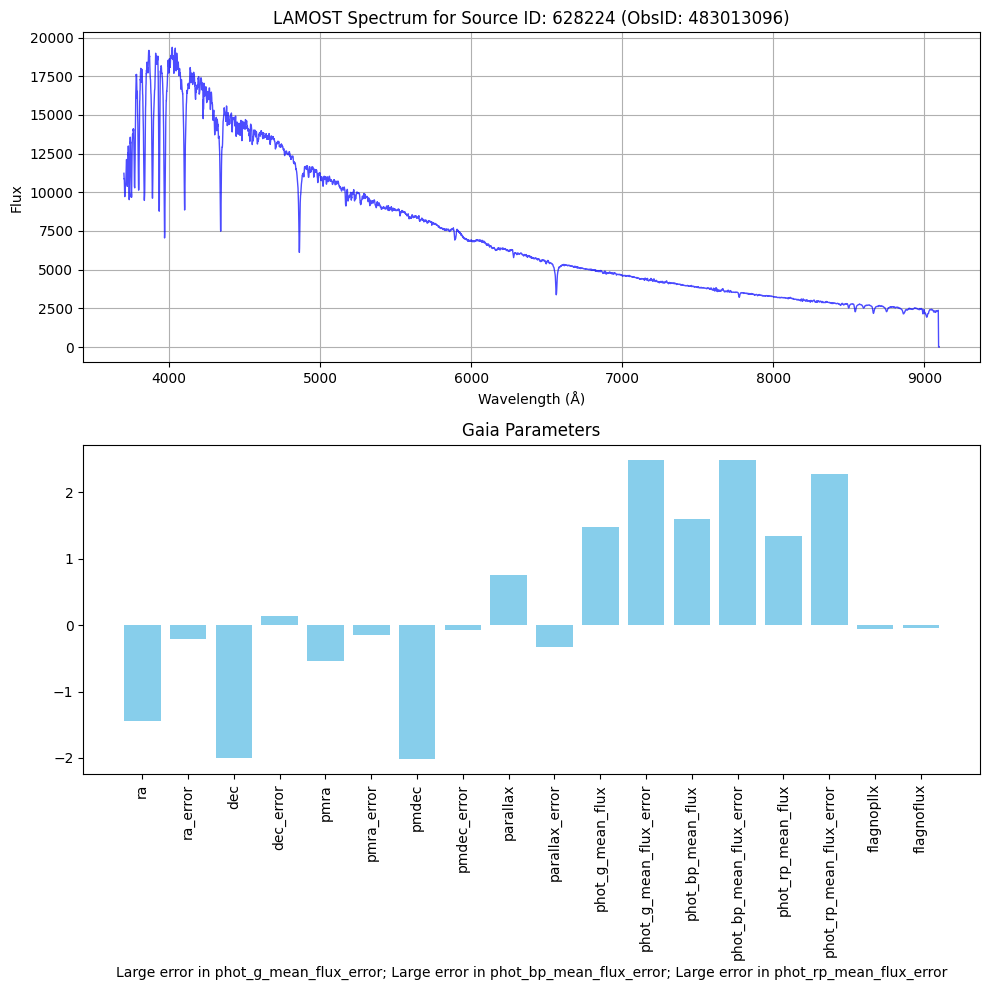

Found match: Source ID 538112 -> ObsID 206705193


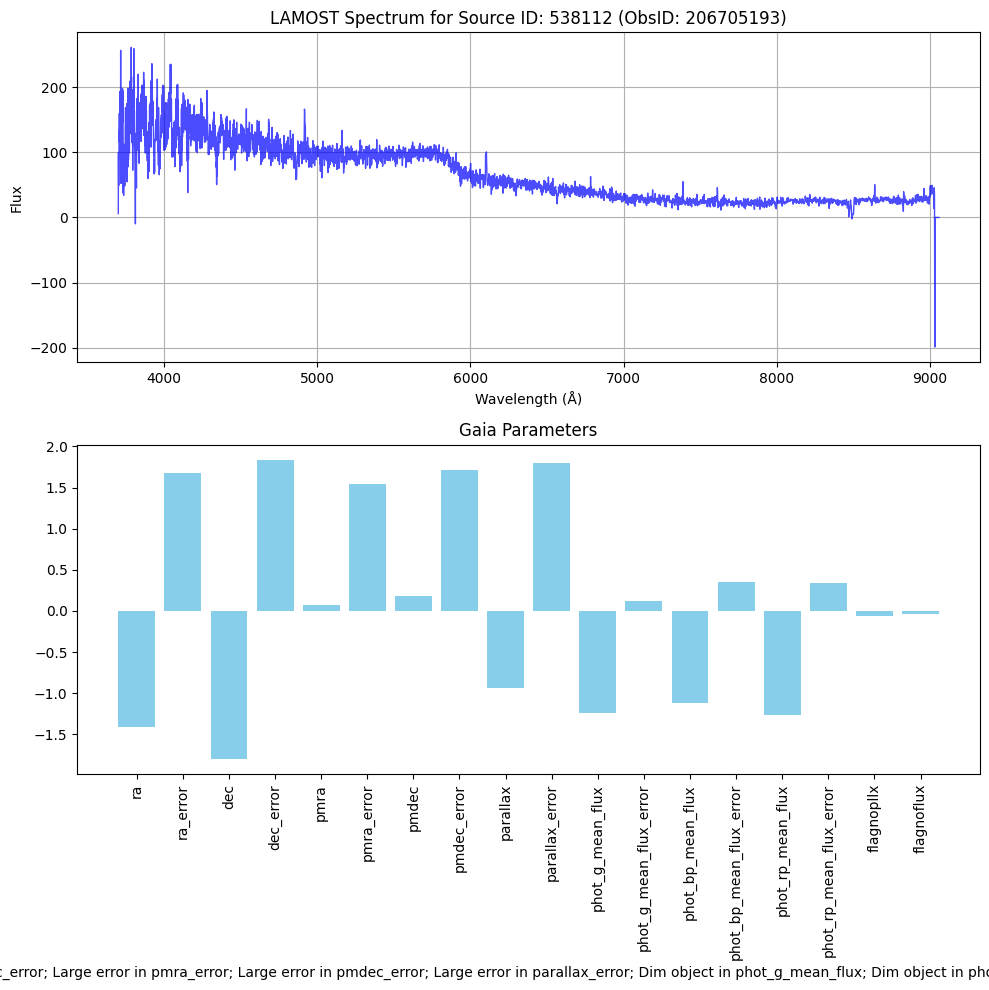

Found match: Source ID 51456 -> ObsID 285402168


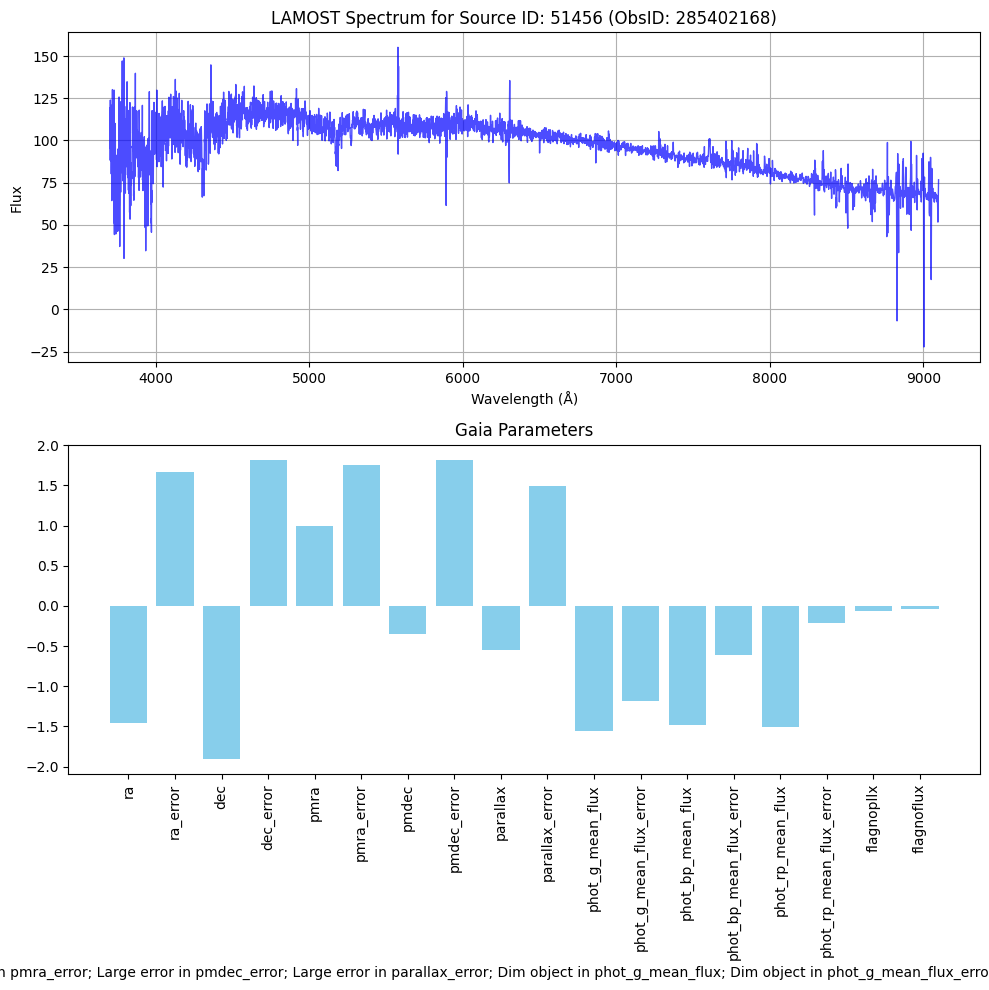

Found match: Source ID 293888 -> ObsID 76205126


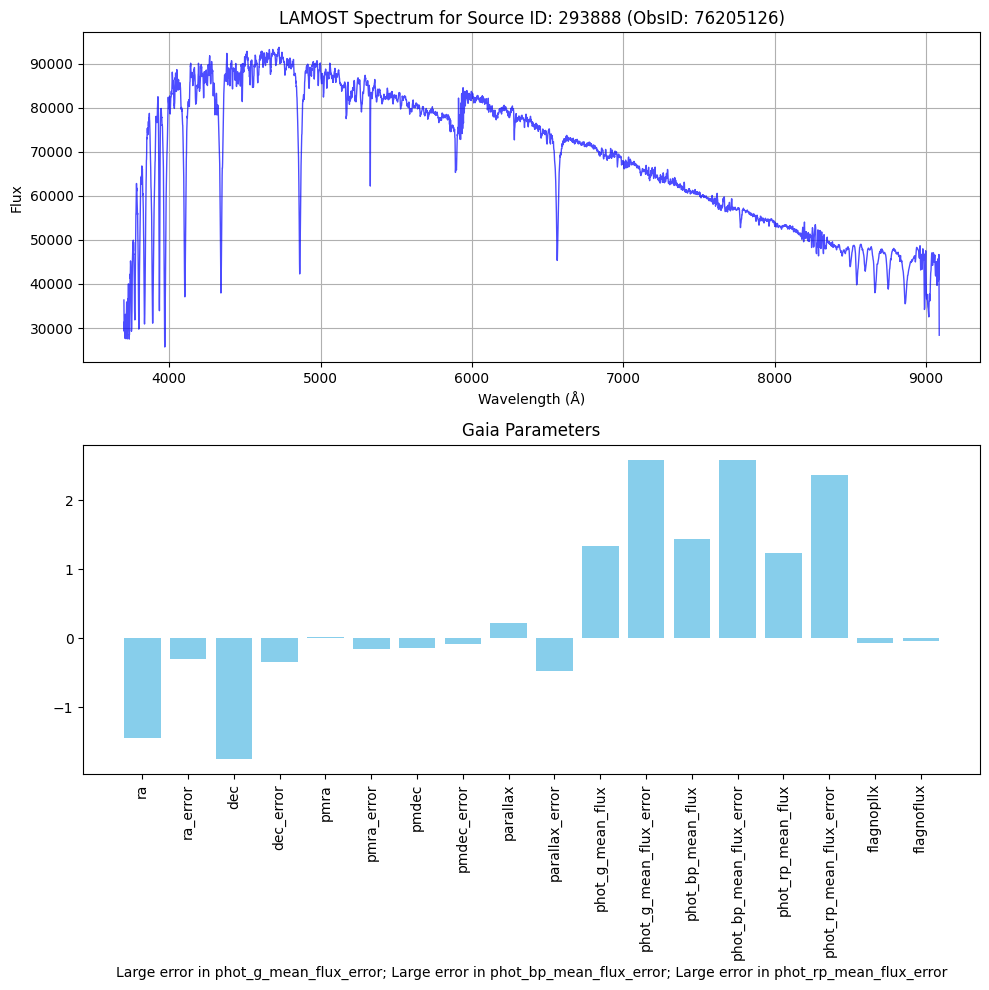

Found match: Source ID 663168 -> ObsID 367316136


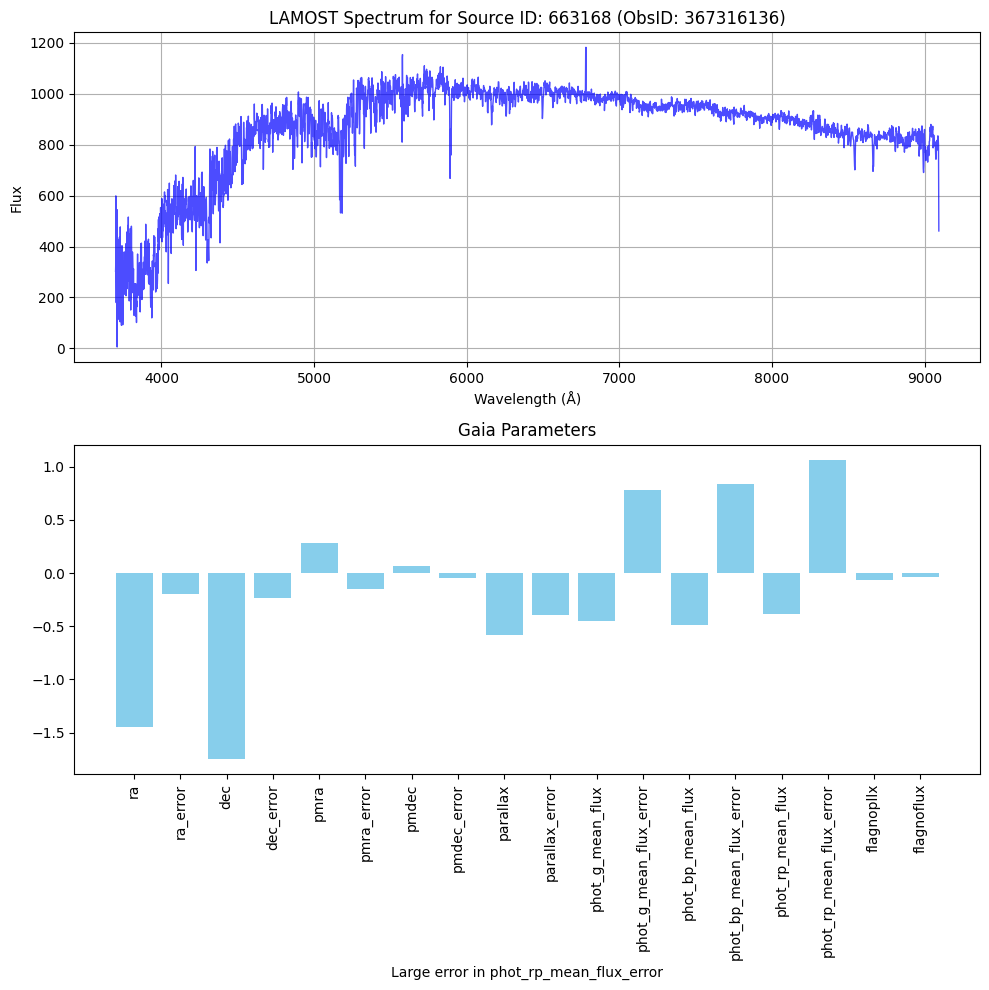

In [14]:
def plot_spectrum_with_gaia(source_id, gaia_lamost_merged, spectra_folder="lamost_spectra_uniques"):
    """
    Plots the LAMOST spectrum from FITS files and displays Gaia parameters below it.
    
    :param source_id: Gaia Source ID of the incorrectly classified source
    :param gaia_lamost_merged: DataFrame containing Gaia and LAMOST cross-matched data
    :param spectra_folder: Path to the folder containing LAMOST FITS spectra
    """
    try:
        if 'obsid' not in gaia_lamost_merged.columns:
            print(f"⚠️ 'obsid' column not found in gaia_lamost_merged.")
            return
        
        match = gaia_lamost_merged.loc[gaia_lamost_merged['source_id'] == source_id]
        if match.empty:
            print(f"⚠️ No LAMOST match found for source_id {source_id}.")
            return
        
        obsid = int(match.iloc[0]['obsid'])
        print(f"Found match: Source ID {source_id} -> ObsID {obsid}")
        
        fits_path = f"{spectra_folder}/{int(obsid)}"
        
        # Load FITS data
        with fits.open(fits_path) as hdul:
            data = hdul[0].data
            if data is None or data.shape[0] < 3:
                print(f"⚠️ Skipping {obsid}: Data not found or incorrect format.")
                return
            
            flux = data[0]
            wavelength = data[2]
            
            fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 3]})
            
            # Plot Spectrum
            ax[0].plot(wavelength, flux, color='blue', alpha=0.7, lw=1)
            ax[0].set_xlabel("Wavelength (Å)")
            ax[0].set_ylabel("Flux")
            ax[0].set_title(f"LAMOST Spectrum for Source ID: {source_id} (ObsID: {obsid})")
            ax[0].grid()
            
            # Show Gaia Data in a Horizontal Bar Plot
            gaia_info = match.iloc[[0]].drop(columns=["source_id", "obsid"], errors='ignore')
            
            # Identify potential data quality issues
            issues = []
            for col in gaia_info.columns:
                value = gaia_info[col].values[0]
                if col.endswith("_error") and value > 1:
                    issues.append(f"Large error in {col}")
                if "_flux" in col and value < -1:
                    issues.append(f"Dim object in {col}")

            issue_text = "; ".join(issues) if issues else "No significant data issues"

            # Drop flux_ columns from bar plot for clarity
            gaia_info = gaia_info.loc[:, ~gaia_info.columns.str.startswith("flux_")]
            if not gaia_info.empty:
                gaia_data = gaia_info.to_dict(orient='records')[0]
                labels = list(gaia_data.keys())
                values = list(gaia_data.values())
                
                ax[1].bar(labels, values, color='skyblue')
                ax[1].tick_params("x", labelrotation=90)
                ax[1].set_xlabel(issue_text)  # Display identified issues below the bar plot
                ax[1].set_title("Gaia Parameters")
            else:
                ax[1].text(0.5, 0.5, "No Gaia Data Available", ha='center', va='center', fontsize=12)
                ax[1].axis("off")
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error loading {fits_path}: {e}")

gaia_lamost_merged['obsid'] = gaia_lamost_merged['obsid'].astype(int)
gaia_lamost_merged['source_id'] = gaia_lamost_merged['source_id'].astype(int)

# Loop through incorrectly classified sources and plot all spectra with labels if gaia data is bad
for source_id in incorrect_gaia_ids.astype(int):
    plot_spectrum_with_gaia(source_id, gaia_lamost_merged)

# Plot Spectra and Gaia version 2 (Optimized for big queries, only plots incorrectly classified data that is "good" on gaia)

In [1]:
def plot_spectrum_with_gaiav2(source_id, gaia_lamost_merged, spectra_folder="lamost_spectra_uniques"):
    """
    Plots the LAMOST spectrum from FITS files and displays Gaia parameters below it,
    only if there are no significant data issues.
    
    :param source_id: Gaia Source ID of the incorrectly classified source
    :param gaia_lamost_merged: DataFrame containing Gaia and LAMOST cross-matched data
    :param spectra_folder: Path to the folder containing LAMOST FITS spectra
    """
    try:
        if 'obsid' not in gaia_lamost_merged.columns:
            print(f"⚠️ 'obsid' column not found in gaia_lamost_merged.")
            return
        
        match = gaia_lamost_merged.loc[gaia_lamost_merged['source_id'] == source_id]
        if match.empty:
            print(f"⚠️ No LAMOST match found for source_id {source_id}.")
            return
        
        obsid = int(match.iloc[0]['obsid'])
        fits_path = f"{spectra_folder}/{obsid}"
        
        # --- Step 1: Check for Gaia Data Issues BEFORE loading FITS ---
        gaia_info = match.iloc[[0]].drop(columns=["source_id", "obsid"], errors='ignore')
        issues = []

        for col in gaia_info.columns:
            value = gaia_info[col].values[0]
            if col.endswith("_error") and value > 1:
                issues.append(f"Large error in {col}")
            if "_flux" in col and value < -1:
                issues.append(f"Dim object in {col}")

        if issues:
            print(f"⚠️ Skipping {obsid}: {', '.join(issues)}")
            return
        
        # --- Step 2: Check FITS File Exists and is Readable ---
        try:
            with fits.open(fits_path, memmap=True) as hdul:
                data = hdul[0].data
        except FileNotFoundError:
            print(f"⚠️ FITS file not found: {fits_path}")
            return
        except Exception as e:
            print(f"⚠️ Error reading FITS file {obsid}: {e}")
            return

        # --- Step 3: Validate FITS Data Format ---
        if data is None or data.shape[0] < 3:
            print(f"⚠️ Skipping {obsid}: Data not found or incorrect format.")
            return
        
        flux = data[0]
        wavelength = data[2]
        
        # --- Step 4: Check for Spectral Data Issues ---
        if np.isnan(flux).any() or np.isnan(wavelength).any():
            print(f"⚠️ Skipping {obsid}: Spectrum contains NaN values.")
            return
        if np.max(flux) > 1e6 or np.min(flux) < -1e6:
            print(f"⚠️ Skipping {obsid}: Flux values are extreme.")
            return

        # --- Step 5: Plot Spectrum ---
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 3]})
        ax[0].plot(wavelength, flux, color='blue', alpha=0.7, lw=1)
        ax[0].set_xlabel("Wavelength (Å)")
        ax[0].set_ylabel("Flux")
        ax[0].set_title(f"LAMOST Spectrum for Source ID: {source_id} (ObsID: {obsid})")
        ax[0].grid()
        
        # --- Step 6: Show Gaia Data in a Horizontal Bar Plot ---
        gaia_info = gaia_info.loc[:, ~gaia_info.columns.str.startswith("flux_")]
        if not gaia_info.empty:
            gaia_data = gaia_info.to_dict(orient='records')[0]
            labels = list(gaia_data.keys())
            values = list(gaia_data.values())
            ax[1].bar(labels, values, color='skyblue')
            ax[1].tick_params("x", labelrotation=90)
            ax[1].set_title("Gaia Parameters")
        else:
            ax[1].text(0.5, 0.5, "No Gaia Data Available", ha='center', va='center', fontsize=12)
            ax[1].axis("off")
        
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error loading {fits_path}: {e}")

# Ensure proper data types
gaia_lamost_merged['obsid'] = gaia_lamost_merged['obsid'].astype(int)
gaia_lamost_merged['source_id'] = gaia_lamost_merged['source_id'].astype(int)

# Loop through incorrectly classified sources and plot spectra only if valid
#for source_id in incorrect_gaia_ids.astype(int):
#    plot_spectrum_with_gaiav2(source_id, gaia_lamost_merged)


NameError: name 'gaia_lamost_merged' is not defined

# Example usage with Cataclysmic Binaries

In [2]:
cat_gaia_ids = []
with open('Pickles/Cataclysmic Bin Catalogue Abrahams et al.txt', 'r') as file:
    for line in file:
        # Check if the line starts with a digit (to avoid header lines)
        if line and line[0].isdigit():
            cat_gaia_ids.append(line[:19].strip())
print(cat_gaia_ids)
print(len(cat_gaia_ids))

['1593140224924964864', '4471866725361723520', '2698490156365025536', '5171137394568701184', '6226943645600487552', '2163612727665972096', '2307289214897332480', '2104562321825510400', '1800384942558699008', '1013298268207936128', '1332378466733219456', '1563999425873420800', '2465053942183130240', '3876618514794039040', '3445477328117272576', '4714563374364671872', '4406459119386466176', '3681313024562519552', '2754909740118313344', '5099482805904892288', '1920126431748251776', '2477023401857408640', '1809844934461976832', '2923643719394227328', '2818311909906928384', '1030279027003254784', '1612331959869359872', '1203263915795342336', '5294908873052262016', '3859020040917830400', '4306244746253355776', '3688359000015020800', '2096274276193099136', '1558322303741820928', '2488974302977323008', '5745881603063095680', '2234727353044624128', '4545086473126911360', '2155490364688727168', '2355217815809560192', '1796893134146598144', '1374430388449392000', '6557154200328277120', '175915658

In [1]:
import pickle

with open('Pickles/gaia_normalization.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)
print(len(data))


{'parallax': PowerTransformer(), 'ra': PowerTransformer(), 'dec': PowerTransformer(), 'ra_error': PowerTransformer(), 'dec_error': PowerTransformer(), 'parallax_error': PowerTransformer(), 'pmra': PowerTransformer(), 'pmdec': PowerTransformer(), 'pmra_error': PowerTransformer(), 'pmdec_error': PowerTransformer(), 'phot_g_mean_flux': PowerTransformer(), 'flagnopllx': PowerTransformer(), 'phot_g_mean_flux_error': PowerTransformer(), 'phot_bp_mean_flux': PowerTransformer(), 'phot_rp_mean_flux': PowerTransformer(), 'phot_bp_mean_flux_error': PowerTransformer(), 'phot_rp_mean_flux_error': PowerTransformer(), 'flagnoflux': PowerTransformer()}
18


In [15]:
# Load the LAMOST catalog to cross-match with Gaia as csv
lamost_catalogue = pd.read_csv("lamost/minimal.csv")  # Load LAMOST catalog (Just obsid and Ra, Dec)
label_cols = pd.read_pickle("Pickles/Updated_List_of_Classes_ubuntu.pkl")

# Example usage:
model_path = "Models/model_fusion_mamba_v4.pth"
gaia_transformers = "Pickles/gaia_normalization.pkl"

df_predictions, gaia_lamost_merged = predict_star_labels(cat_gaia_ids, model_path, lamost_catalogue, gaia_transformers)

# Save the predictions to a npy file
np.save("y_predictions_cat.npy", df_predictions)


🚀 Step 1: Querying Gaia data...
🔗 Gaia IDs: 500
INFO: Query finished. [astroquery.utils.tap.core]
Missing IDs: {'2871939764914510976', '4676468869876208128', '3391618889196357248', '5365680794401390336', '3699606286708406912', '4537992286672097280', '2947045278211416960', '5759752908615824128', '6492236727426610304', '4200218019655998720', '2494281851762928512', '6782793537041886464', '6164939367406725632', '2147082017019347968', '4409581010854168064', '1729491319015998208', '3221858928137002880', '4918835764173746432', '4744804750196738560', '2427474150870397056', '2838503311371673472', '2901783160488793728', '5099482805904892288', '4701058897674276736', '2105585421693855744', '1074721664954807040', '1809844934461976832', '3446676070669830528', '2069105580089321472', '2163877198882886656', '1872069664728668288', '3133113805608088064', '1108037726271701248', '4501373322484989952', '5710870820677041664', '2177784092519048704', '2913032092154691200', '2218642047686814208', '524278748641

❌ Failed to download 7 spectra:
  obsid=866605170 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/866605170 (Caused by ResponseError('too many 500 error responses'))
  obsid=823606181 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/823606181 (Caused by ResponseError('too many 500 error responses'))
  obsid=757314103 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/757314103 (Caused by ResponseError('too many 500 error responses'))
  obsid=797001189 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/797001189 (Caused by ResponseError('too many 500 error responses'))
  obsid=814503145 => Error: HTTPSConnectionPool(host='www.lamost.org', port=443): Max retries exceeded with url: /dr7/v2.0/spectrum/fits/814503145 (

Processing FITS files: 100%|██████████| 58/58 [00:00<00:00, 574.34it/s]

⚠️ Error processing 195807009: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
⚠️ Error processing 409102003: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True


Processing FITS files: 100%|██████████| 58/58 [00:00<00:00, 149.29it/s]



📊 Step 5: Extracting and saving flux & frequency values...

📊 Extracting flux and frequency values...


1it [00:00, 23.01it/s]


✅ Flux values shape: (56, 3749), Frequency values shape: (56, 3749)

📊 Step 6: Interpolating and normalizing LAMOST spectra...


Interpolating spectra: 100%|██████████| 56/56 [00:00<00:00, 643.45it/s]


Initial number of rows: 56
Total successful interpolations: 56
Total skipped rows (NaNs + zeros): 0
Final check: len(df_flux) == cnt_success + len(nan_files)? True


/tmp/ipykernel_10369/3061469949.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia_lamost_match["obsid"] = gaia_lamost_match["obsid"].astype(int)



📊 Step 7: Normalizing Gaia data...
Dropped 0 rows with NaN values.

🔗 Step 8: Merging Gaia and LAMOST data...

🤖 Step 9: Predicting labels using the trained model...
X_spectra shape: (56, 3647)
X_gaia shape: (56, 18)

💾 Step 10: Saving predictions...


In [18]:
# Load the predictions and class labels
y_pred = np.load("y_predictions_cat.npy")
y_pred = np.array(y_pred, dtype=int)
print(y_pred)
classes = pd.read_pickle("Pickles/Updated_List_of_Classes_ubuntu.pkl")

print(classes)

# Generate the expected y_true for eclipsing binaries
y_true = np.zeros_like(y_pred)
y_true[:, -14] = 1  # "CV*" column
y_true[:, 1] = 1   # "**" column (second column)

# Compute precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
#recall = recall_per_label(y_true, y_pred, average=None, zero_division=0)
#f1 = f1_per_label(y_true, y_pred, average=None, zero_division=0)

# Create a DataFrame to store metrics per class
metrics_df = pd.DataFrame({
    "Class": classes,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

# Identify Correctly Classified Samples (True Positives)
correct_predictions = (y_pred == y_true).all(axis=1)
correct_gaia_ids = df_predictions.loc[correct_predictions, "source_id"]

# Identify incorrectly classified samples (False Positives and False Negatives)
incorrect_predictions = (y_pred != y_true).any(axis=1)
incorrect_gaia_ids = df_predictions.loc[incorrect_predictions, "source_id"]

# Display incorrectly classified Gaia IDs
print("\n🔍 Incorrectly Classified Gaia IDs:")
print(pd.DataFrame({"source_id": incorrect_gaia_ids}))

# Display the performance metrics for the non-zero classes
print("\n📊 Performance Metrics:")
metrics_df = metrics_df[metrics_df["Precision"] > 0]
print(metrics_df)

[[                  0                   1                   0 ...
                    0                   0 1014962001098647680]
 [                  0                   1                   0 ...
                    0                   0 1028258463932870656]
 [                  0                   1                   0 ...
                    0                   0 1108037726271701248]
 ...
 [                  0                   1                   0 ...
                    0                   0 3886153548349816832]
 [                  0                   1                   0 ...
                    0                   0 3958581402928688640]
 [                  0                   1                   0 ...
                    0                   0 4503256687122329088]]
['RS*', '**', 'El*', 'Y*O', 's*b', 'cC*', 'HB*', 'dS*', 'Or*', 'LP*', 'BS*', 'Ae*', 'WV*', 'HS*', 'Ev*', 'AB*', 'sg*', 's*r', 'Ce*', 'gD*', 'OH*', 'HXB', 'Pu*', 'RV*', 'Sy*', 'V*', 'TT*', 'SN*', 'Be*', 'SB*', 'Em*', 'Er*

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass-multioutput targets